In [ ]:
!pip install fastai
!pip install fastcore

In [ ]:
!pip install torch

In [ ]:
!pip install torchvision==0.15.1 # I noticed that some envs cannot find this version so but 0.14.1 seems to work as well

In [1]:
!wget --no-check-certificate http://astro.utoronto.ca/~hleung/shared/Galaxy10/Galaxy10_DECals.h5

--2023-04-12 12:11:56--  http://astro.utoronto.ca/~hleung/shared/Galaxy10/Galaxy10_DECals.h5
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 301 Moved Permanently
Location: https://astro.utoronto.ca/~hleung/shared/Galaxy10/Galaxy10_DECals.h5 [following]
--2023-04-12 12:11:56--  https://astro.utoronto.ca/~hleung/shared/Galaxy10/Galaxy10_DECals.h5
Connecting to 10.99.0.130:3128... connected.
  Unable to locally verify the issuer's authority.
Proxy request sent, awaiting response... 301 Moved Permanently
Location: https://www.astro.utoronto.ca/~hleung/shared/Galaxy10/Galaxy10_DECals.h5 [following]
--2023-04-12 12:11:56--  https://www.astro.utoronto.ca/~hleung/shared/Galaxy10/Galaxy10_DECals.h5
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2735267419 (2.5G)
Saving to: ‘Galaxy10_DECals.h5’

Galaxy10_DECals.h5  100%[===================>]   2.55G   100MB/s    in 28s     

2023-04-12 12:12:25 (94.6 MB/

In [2]:
import torch

In [3]:
torch. __version__

'2.0.0+cu117'

In [4]:
from fastai.basics import *
from fastai.vision.all import *

import h5py
from torchvision import transforms

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
with h5py.File('Galaxy10_DECals.h5', 'r') as f:
    images = np.array(f['images'])
    labels = np.array(f['ans'])

In [6]:
from IPython.display import display

<AxesSubplot:>

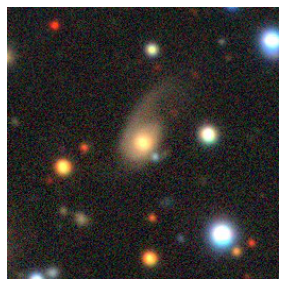

In [7]:
im = PILImage.create(images[52])
im.show(figsize=(5,5))

In [8]:
def make_dataloaders_from_numpy_data(image, label):
    def pass_index(idx):
        return idx

    def get_x(i):
        # NOTE: This is a grayscale image that appears to just work with a network expecting RGB.
        # I suspect this is due to tensor broadcasting rules.
        return image[i]

    def get_y(i):
        return label[i]

    dblock = DataBlock(
        blocks=(ImageBlock, CategoryBlock),
        get_items=pass_index,
        get_x=get_x,
        get_y=get_y,
        # item_tfms = Resize(224),
        # item_tfms=Resize(460),
        batch_tfms=aug_transforms(size=224) #I know added data augmentation
        )

    # pass in a list of index
    num_images = image.shape[0]
    dls = dblock.dataloaders(list(range(num_images)))

    return dls

In [9]:
dls = make_dataloaders_from_numpy_data(images, labels)

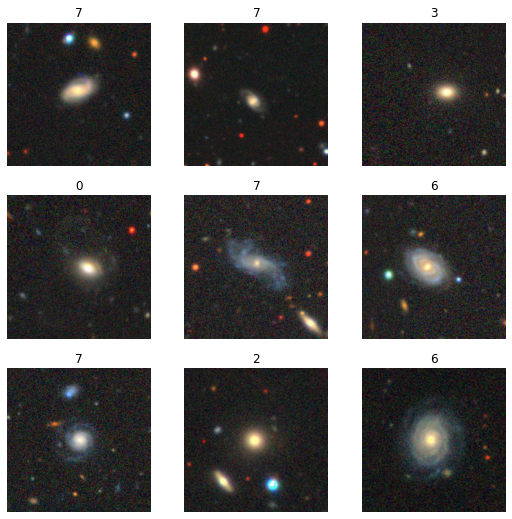

In [10]:
# Checking the data
dls.show_batch()

In [11]:
# I used "vision_learner" but I will later try to use "cnn_learner" as it is more specific for this task
learn = cnn_learner(dls, resnet18, metrics=[accuracy, error_rate])

/home/o.f/.local/lib/python3.9/site-packages/fastai/vision/learner.py:288: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
/home/o.f/.local/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/o.f/.local/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


SuggestedLRs(valley=0.002511886414140463)

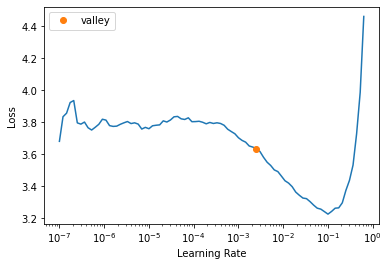

In [12]:
# Finding the learning rate
learn.lr_find()

In [13]:
# Fine-tune the pre-trained model on your specific dataset. 
# This method automatically freezes the early layers of the model and 
# trains the later layers, gradually unfreezing more layers as needed.
# Is not necessary to put the lr here to make it work.
# learn.fine_tune(5, 1e-3)
learn.fine_tune(5)

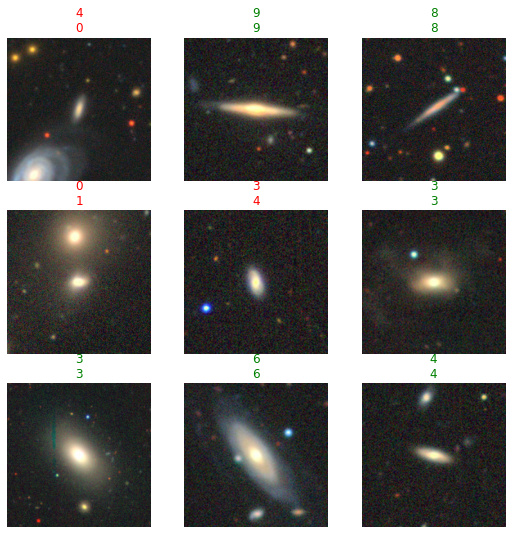

In [14]:
learn.show_results()

In [15]:
interp = Interpretation.from_learner(learn)

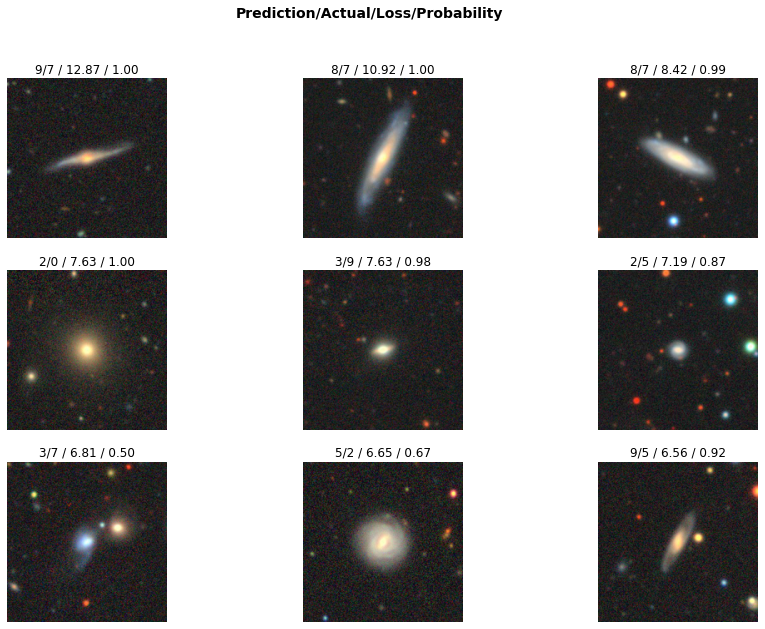

In [16]:
interp.plot_top_losses(9, figsize=(15,10))

In [17]:
learn.validate()

(#3) [0.7690960764884949,0.7394981384277344,0.26050183176994324]

In [20]:
# This method trains the model using the 1cycle policy, which involves gradually 
# increasing and then decreasing the learning rate over the course of training.
# It can be customized with wd and other parameters
learn.fit_one_cycle(100, 1e-3)

In [21]:
from fastai.test_utils import *

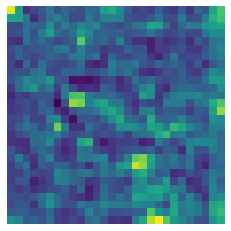

In [22]:
# Extract the output of a specific layer
layer = learn.model[0][5]  # Select the 5th convolutional layer
hook = Hook(layer, lambda m,i,o: o)

# Get a batch of images from the validation set
x,y = dls.valid.one_batch()
x.requires_grad_(True)

# Pass the batch of images through the model and get the output of the selected layer
learn.model.eval()
with torch.no_grad():
    output = learn.model(x)
    
# Generate the activation maps
acts = hook.stored[0].cpu()
avg_acts = acts.mean(0)

# Display the activation maps as a heatmap
plt.imshow(avg_acts, cmap='viridis')
plt.axis('off')
plt.show()

In [23]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [24]:
learn.model[0][5]

Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (downsample): Sequential(
      (0): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (1): BasicBlock(
    (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(128, eps=1e-

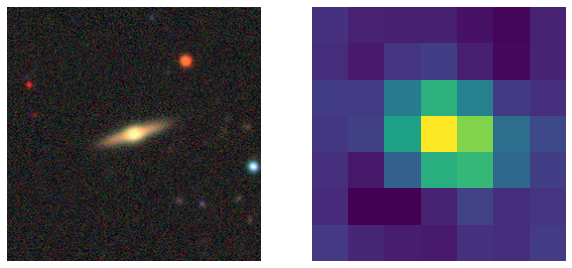

In [25]:
# Extract the output of a specific layer
layer = learn.model[0][7]  # Select the 5th convolutional layer
hook = Hook(layer, lambda m,i,o: o)

# Get a batch of images from the validation set
x,y = dls.valid.one_batch()
x.requires_grad_(True)

# Pass the batch of images through the model and get the output of the selected layer
learn.model.eval()
with torch.no_grad():
    output = learn.model(x)
    
# Generate the activation maps
acts = hook.stored[0].cpu()
avg_acts = acts.mean(0)

# Display the activation maps as a heatmap
# plt.imshow(avg_acts, cmap='viridis')
# plt.axis('off')
# plt.show()

# Display the original image and activation maps side-by-side
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(dls.train_ds[0][0])
axs[0].axis('off')
axs[1].imshow(avg_acts, cmap='viridis')
axs[1].axis('off')
plt.show()

I'm still stuck here

In [28]:
len(learn.model[0])

8

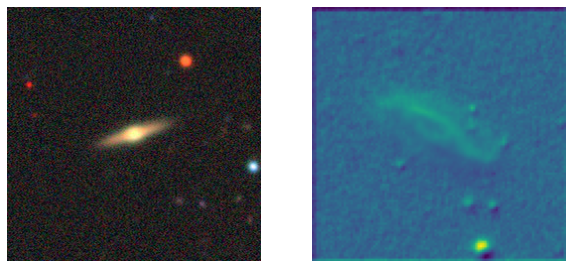

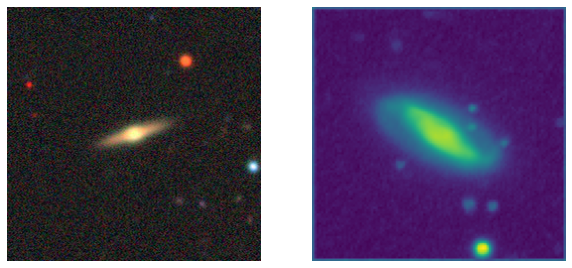

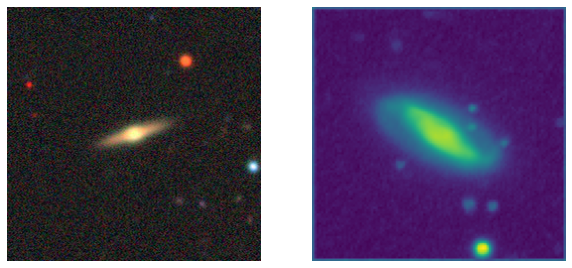

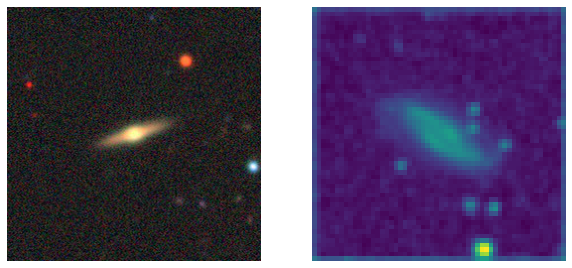

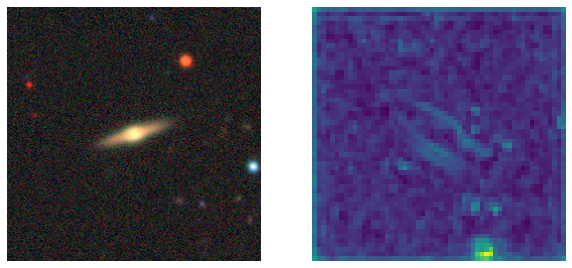

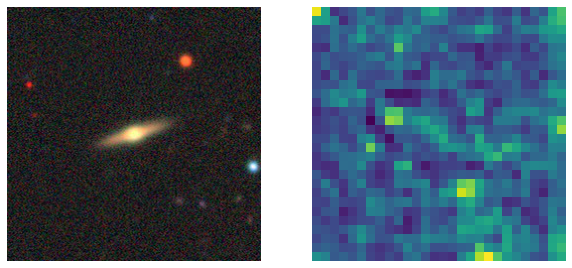

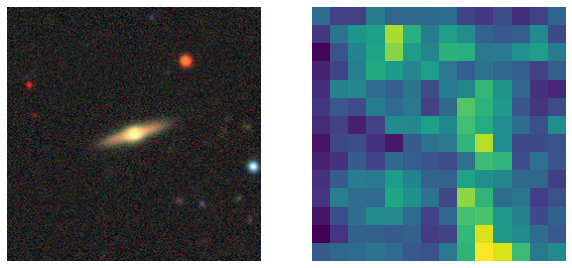

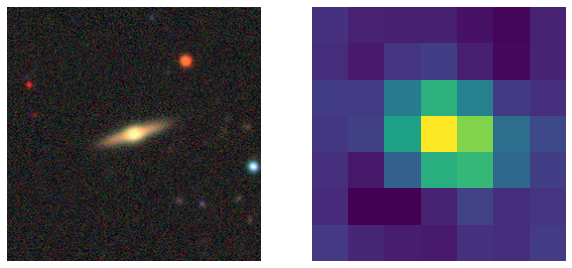

In [29]:
# Extract the output of a specific layer
for i in range(len(learn.model[0])):
    layer = learn.model[0][i]  # Select the 5th convolutional layer
    hook = Hook(layer, lambda m,i,o: o)

    # Get a batch of images from the validation set
    x,y = dls.valid.one_batch()
    x.requires_grad_(True)

    # Pass the batch of images through the model and get the output of the selected layer
    learn.model.eval()
    with torch.no_grad():
        output = learn.model(x)

    # Generate the activation maps
    acts = hook.stored[0].cpu()
    avg_acts = acts.mean(0)

    # Display the activation maps as a heatmap
    # plt.imshow(avg_acts, cmap='viridis')
    # plt.axis('off')
    # plt.show()

    # Display the original image and activation maps side-by-side
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(dls.train_ds[0][0])
    axs[0].axis('off')
    axs[1].imshow(avg_acts, cmap='viridis')
    axs[1].axis('off')
    plt.show()

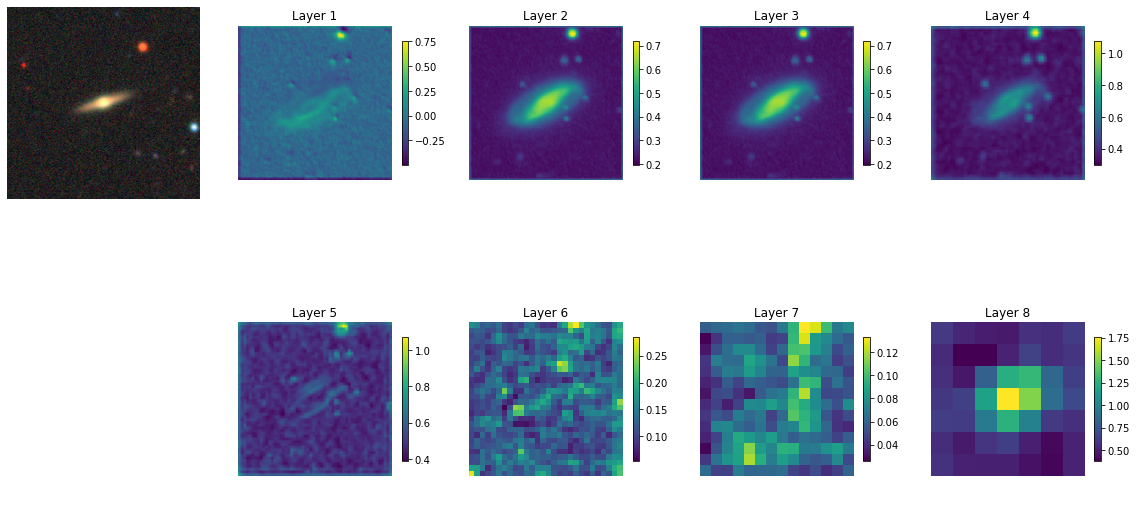

In [36]:
num_layers = len(learn.model[0])
num_cols = min(4, num_layers)
num_rows = (num_layers-1) // num_cols + 1

fig, axs = plt.subplots(num_rows, num_cols+1, figsize=(5*num_cols, 5*num_rows))
axs[0, 0].imshow(dls.train_ds[0][0])
axs[0, 0].axis('off')
axs[1, 0].axis('off')
for i in range(num_layers):
    layer = learn.model[0][i]
    hook = Hook(layer, lambda m, i, o: o)

    x, y = dls.valid.one_batch()
    x.requires_grad_(True)

    with torch.no_grad():
        output = learn.model(x)

    acts = hook.stored[0].cpu()
    avg_acts = acts.mean(0)

    row = i // num_cols
    col = i % num_cols + 1

    im = axs[row, col].imshow(avg_acts, cmap='viridis', origin='lower')
    axs[row, col].axis('off')
    axs[row, col].set_title(f"Layer {i+1}")

    cbar = fig.colorbar(im, ax=axs[row, col], shrink=0.5)

plt.show()

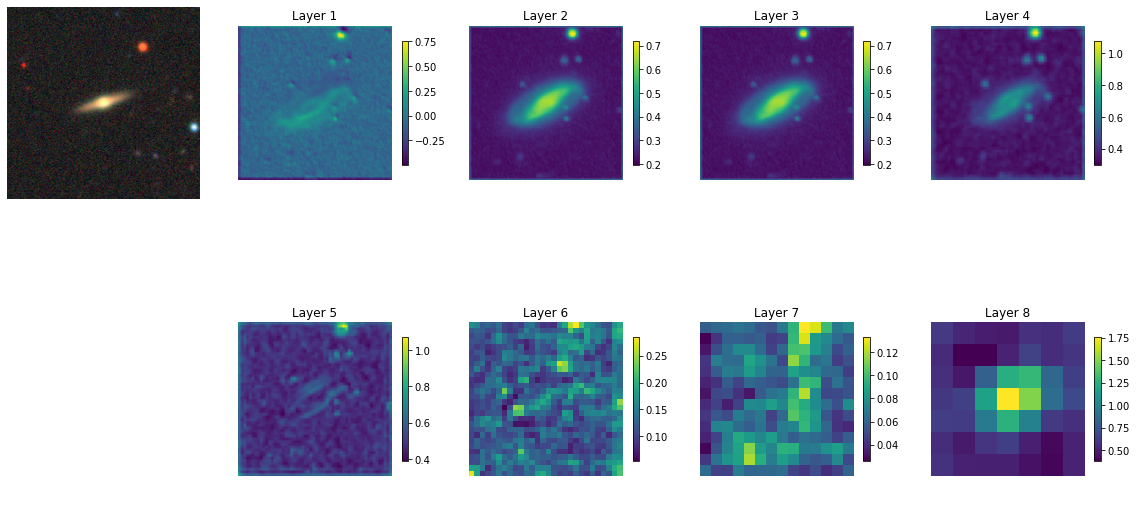

In [72]:
num_layers = len(learn.model[0])
num_cols = min(4, num_layers)
num_rows = (num_layers-1) // num_cols + 1

fig, axs = plt.subplots(num_rows, num_cols+1, figsize=(5*num_cols, 5*num_rows))
axs[0, 0].imshow(dls.train_ds[0][0])
axs[0, 0].axis('off')
axs[1, 0].axis('off')

x, y = dls.valid.one_batch()
x.requires_grad_(True)

for i in range(num_layers):
    layer = learn.model[0][i]
    hook = Hook(layer, lambda m, i, o: o)

    with torch.no_grad():
        output = learn.model(x)

    acts = hook.stored[0].cpu()
    avg_acts = acts.mean(0)

    row = i // num_cols
    col = i % num_cols + 1

    im = axs[row, col].imshow(avg_acts, cmap='viridis', origin='lower')
    axs[row, col].axis('off')
    axs[row, col].set_title(f"Layer {i+1}")

    cbar = fig.colorbar(im, ax=axs[row, col], shrink=0.5)

plt.show()

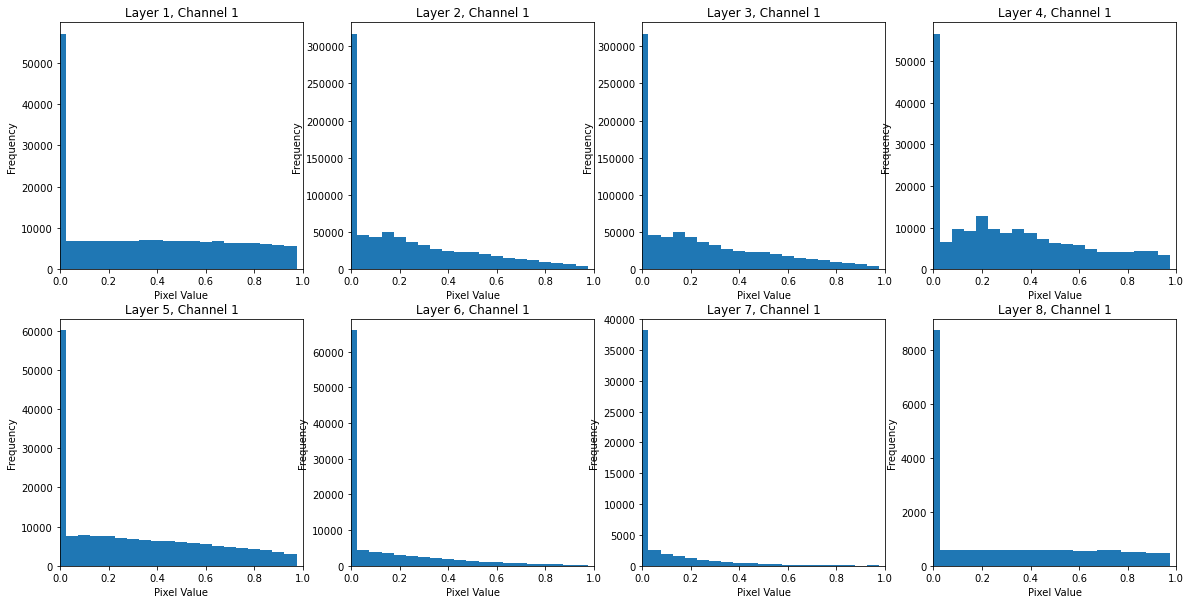

In [68]:
num_layers = len(learn.model[0])   
num_cols = min(num_layers, 4)  
num_rows = (num_layers-1) // num_cols + 1  
fig, axs = plt.subplots(num_rows, num_cols, figsize=(5*num_cols, 5*num_rows))  
for i in range(num_layers):
    layer = learn.model[0][i] 
    hook = Hook(layer, lambda m, i, o: o)
    x, y = dls.valid.one_batch()
    x.requires_grad_(True)       
    with torch.no_grad():
        output = learn.model(x)
        acts = hook.stored[0].cpu()
    # Add an extra dimension to acts:
    acts = acts.unsqueeze(1)
    # Permute the tensor dimensions correctly:
    acts = acts.permute(0, 2, 3, 1)
    num_channels = acts.shape[3]
    for j in range(num_channels):
        channel_acts = acts[:, :, :, j].flatten() # get activations for current channel
        hist, bins = np.histogram(channel_acts, bins=20, range=(0, 1))
        row = (i+j) // num_cols
        col = (i+j) % num_cols  
        axs[row, col].bar(bins[:-1], hist, width=(bins[1]-bins[0]), align='center')
        axs[row, col].set_title(f"Layer {i+1}, Channel {j+1}") 
        axs[row, col].set_xlim([0, 1]) 
        axs[row, col].set_xlabel("Pixel Value")
        axs[row, col].set_ylabel("Frequency")
plt.show()

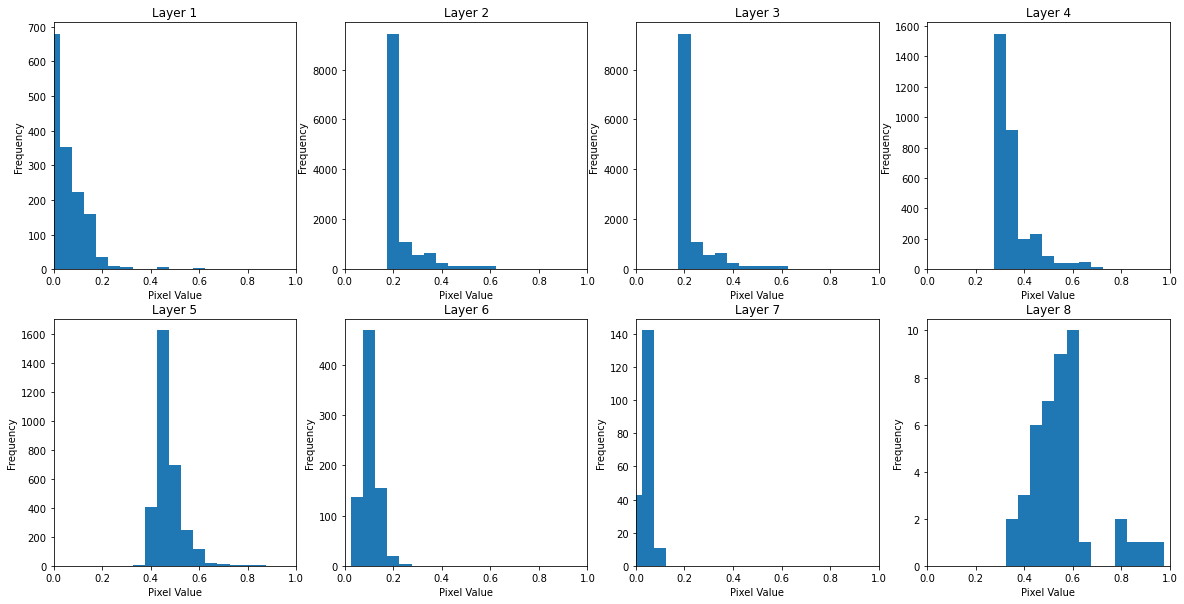

In [49]:
num_layers = len(learn.model[0])   

num_cols = min(num_layers, 4)  

num_rows = (num_layers-1) // num_cols + 1  

fig, axs = plt.subplots(num_rows, num_cols, figsize=(5*num_cols, 5*num_rows))  

for i in range(num_layers):
    layer = learn.model[0][i] 
    hook = Hook(layer, lambda m, i, o: o)
    x, y = dls.valid.one_batch()
    x.requires_grad_(True)       
    
    with torch.no_grad():
        output = learn.model(x)
        acts = hook.stored[0].cpu()
        
    avg_acts = acts.mean(0).flatten() 
    
    hist, bins = np.histogram(avg_acts, bins=20, range=(0, 1))
    
    row = i // num_cols
    col = i % num_cols  
    
    axs[row, col].bar(bins[:-1], hist, width=(bins[1]-bins[0]), align='center')
    
    axs[row, col].set_title(f"Layer {i+1}") 
    axs[row, col].set_xlim([0, 1]) 
    axs[row, col].set_xlabel("Pixel Value")
    axs[row, col].set_ylabel("Frequency")
    
plt.show()  

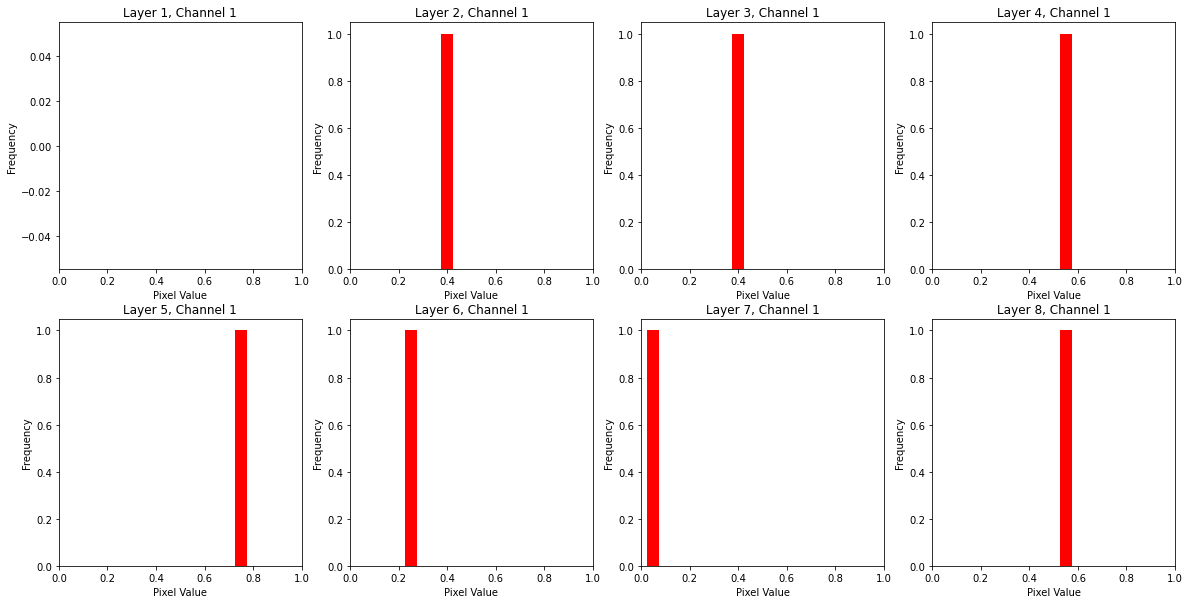

In [55]:
num_layers = len(learn.model[0])   
num_cols = min(num_layers, 4)  
num_rows = (num_layers-1) // num_cols + 1  
fig, axs = plt.subplots(num_rows, num_cols, figsize=(5*num_cols, 5*num_rows))  

for i in range(num_layers):
    layer = learn.model[0][i] 
    hook = Hook(layer, lambda m, i, o: o)
    x, y = dls.valid.one_batch()
    x.requires_grad_(True) 
    
    with torch.no_grad():
        output = learn.model(x)
        acts = hook.stored[0].cpu()
    
    if len(acts.shape) == 4: # for convolutional layers
        num_filters = acts.shape[0]
        num_channels = acts.shape[1]
        acts = acts.permute(1, 0, 2, 3).reshape(num_channels, -1)
    else: # for linear layers
        acts = acts.mean(0).flatten()
        num_channels = 1
    
    for j in range(num_channels):
        hist, bins = np.histogram(acts[j], bins=20, range=(0, 1))
        
        row = (i*num_channels + j) // num_cols
        col = (i*num_channels + j) % num_cols 
        
        axs[row, col].bar(bins[:-1], hist, width=(bins[1]-bins[0]), align='center', color=['red', 'green', 'blue'][j])
        axs[row, col].set_title(f"Layer {i+1}, Channel {j+1}") 
        axs[row, col].set_xlim([0, 1]) 
        axs[row, col].set_xlabel("Pixel Value")
        axs[row, col].set_ylabel("Frequency")
    
plt.show()